## Neural Networks with PSD features, theta and alpha bands only


In [29]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline 
# %matplotlib qt


In [30]:
# Import datasets
psd_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\PSD_only\PSD_df_12.pkl")
auc_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\AUC_only\AUC_df_12.pkl")
AP_df = pd.read_pickle("F:\EEG-data\\think-count\\featureExtraction\AUC_PSD\AUC_PSD_df_12.pkl")

In [44]:
#Baseline model
def baseline_func(no_features):
    ANN_model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(8,32)),
    keras.layers.Dense(no_features,input_dim=no_features,activation='relu'),
    keras.layers.Dense(no_features/2, activation='relu'),
    keras.layers.Dense(no_features/4, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')])

    ANN_model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics = ['accuracy'])
    return ANN_model

#Cross Validation and Prediction
def apply_CV_predict(baseline_func,df,filename,savedir):
    #Split into training and test sets 
    class_names = ["T","C"]
    X = df.iloc[:,:-1].values.astype(np.float32)
    y = df['Action'].apply(class_names.index).values.astype(np.float32)
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for train_index, test_index in sss.split(X,y):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
    no_features = X.shape[1]
    #Cross Validation 
    epochsList = list(range(1,20))
    mean_results = [] 
    kfold = StratifiedShuffleSplit(n_splits=10)
    for epoch in epochsList:
        estimator=KerasClassifier(build_fn=lambda:baseline_func(no_features),epochs=epoch,batch_size=5,verbose=0)
        result = np.mean(cross_val_score(estimator,X_train,y_train,cv=kfold,scoring="f1_macro"))
        mean_results.append(result)
    mean_results = np.array(mean_results)
    best_epoch = epochsList[np.argmax(mean_results)]
    #Test set evaluation
    final_estimator = KerasClassifier(build_fn=lambda:baseline_func(no_features),epochs=best_epoch,batch_size=5,verbose=0)
    final_estimator.fit(X_train,y_train)
    y_pred = final_estimator.predict(X_test)
    #F1 Score
    f1Score = f1_score(y_test,y_pred)
    #Confusion matrix
    cm = confusion_matrix(y_test,y_pred,normalize='true')
    # fig,ax = plt.subplots()
    # ax.set_title(filename+'CM')
    # plot_confusion_matrix(final_estimator,X_test,y_test,labels=class_names,ax=ax,normalize='true')
    # plt.savefig(savedir+filename+'.png')
    # plt.close()
    return f1Score,cm

In [45]:
#Directories to save to
savedir = "F:\EEG-data\\think-count\ANN/"
PSD_filename = "PSD_"
AUC_filename = "AUC_"
AP_filename = "AP_"

PSD_f1Score,PSD_cm = apply_CV_predict(baseline_func,psd_df,PSD_filename,savedir)

In [46]:
AUC_f1Score,AUC_cm = apply_CV_predict(baseline_func,auc_df,AUC_filename,savedir)


In [47]:
AP_f1Score,AP_cm = apply_CV_predict(baseline_func,AP_df,AP_filename,savedir)

In [48]:
print("PSD F1 Score:",PSD_f1Score)
print("AUC F1 Score:",AUC_f1Score)
print("AP F1 Score:",AP_f1Score)

PSD F1 Score: 0.7681159420289855
AUC F1 Score: 0.7819548872180452
AP F1 Score: 0.7969924812030075


In [49]:
print(PSD_cm)
print(AUC_cm)
print(AP_cm)

[[0.671875 0.328125]
 [0.171875 0.828125]]
[[0.734375 0.265625]
 [0.1875   0.8125  ]]
[[0.75     0.25    ]
 [0.171875 0.828125]]


In [10]:
class_names = ["T","C"]
# X = psd_df.iloc[:,:-1].values.reshape((X.shape[0],-1,32)).astype(np.float32)
X = psd_df.iloc[:,:-1].values.astype(np.float32)
y = psd_df['Action'].apply(class_names.index).values.astype(np.float32)
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]

In [85]:
print(X.shape)
print(y.shape)

(640, 256)
(640,)


In [130]:
labels = psd_df.iloc[:,-1].values
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)

In [173]:
a = encoded_labels.astype(np.float32)

In [8]:
#baseline model
def create_baseline():
    ANN_model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(8,32)),
    keras.layers.Dense(256,input_dim=256,activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')])

    ANN_model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics = ['accuracy'])
    return ANN_model


In [11]:
estimator = KerasClassifier(build_fn=create_baseline,epochs=10,batch_size=5,verbose=0)
# kfold = StratifiedShuffleSplit(n_splits=10)
# results = cross_val_score(estimator,X,y,cv=kfold)

In [146]:
def cross_validate(baselineFun,epochsList,X,y):
    mean_results = [] 
    kfold = StratifiedShuffleSplit(n_splits=10)
    for epoch in epochsList:
        estimator=KerasClassifier(build_fn=baselineFun,epochs=epoch,batch_size=5,verbose=0)
        result = np.mean(cross_val_score(estimator,X,y,cv=kfold))
        mean_results.append(result)
    return mean_results
        


In [168]:
epochsList = list(range(1,20))
mean_results = cross_validate(create_baseline,epochsList,X_train,y_train)

In [169]:
mean_results = np.array(mean_results)
epochsList[np.argmax(mean_results)]

8

In [12]:
final_estimator = KerasClassifier(build_fn=create_baseline,epochs=8,batch_size=5,verbose=0)
final_estimator.fit(X_train,y_train)

In [13]:
y_pred = final_estimator.predict(X_test)

In [172]:
f1_score(y_test,y_pred)

0.765625

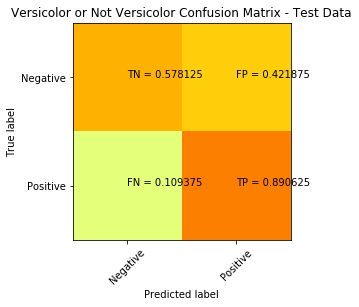

In [25]:
fig,ax = plt.subplots()
# print(type(final_estimator))
cm = confusion_matrix(y_test,y_pred,normalize='true')
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [167]:
final_model=create_baseline()
final_model.fit(X_train,y_train,epochs=15,verbose=0)
final_model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.9061 - accuracy: 0.7422


[0.906097412109375, 0.7421875]

In [155]:
print(mean_results)

[0.6859375 0.7640625 0.7703125 0.753125  0.8       0.75625   0.7953125
 0.78125   0.821875  0.7984375 0.821875  0.8265625 0.83125   0.8421875
 0.84375   0.8109375 0.8046875 0.8203125 0.828125 ]


In [107]:
ANN_model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(8,32)),
    keras.layers.Dense(256,input_dim=256,activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [127]:
ANN_model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics = ['accuracy'])

In [128]:
#Model training
ANN_model.fit(X_train,y_train,epochs=1)

16/16 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000


In [129]:
test_loss, test_acc = ANN_model.evaluate(X_test,y_test,verbose=1)
print("Test accuracy:",test_acc)

4/4 [==============================] - 0s 2ms/step - loss: 1.2674 - accuracy: 0.7578
Test accuracy: 0.7578125
